In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [31]:

df=pd.read_csv("C:/Users/yoonk/Desktop/real.csv",index_col = 'No').reset_index(drop = True)
df.head()


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [33]:
df.columns = ['date','age','dist_mrt','cvs','lat','long','price']
df['date'] = pd.Series([str(x)[:4] for x in df['date']]).astype('category')

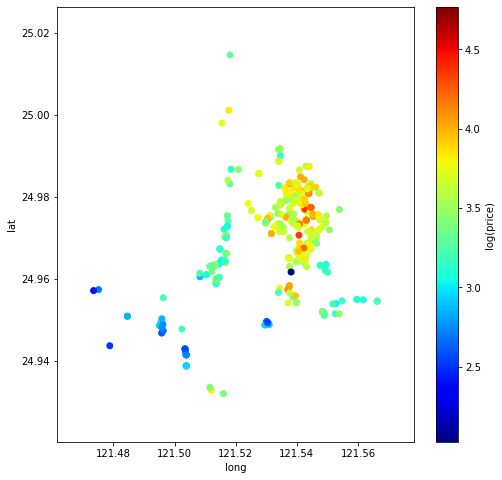

In [34]:
fig = plt.figure(figsize = (8,8))
plt.scatter(x=df.long, y = df.lat, alpha = 4, c = np.log(df.price), cmap = plt.get_cmap('jet'))
plt.xlabel('long')
plt.ylabel('lat')
cbar = plt.colorbar()
cbar.ax.set_ylabel("log(price)")
plt.show()

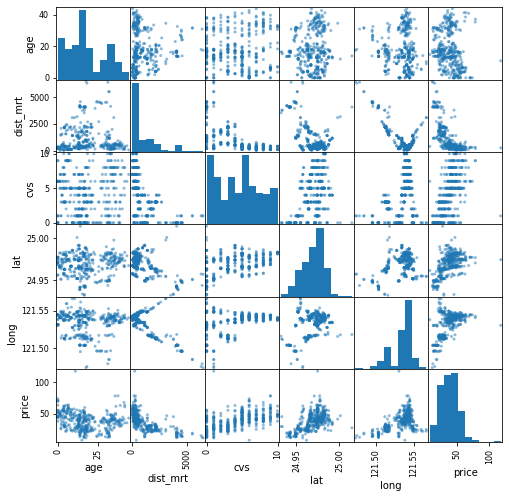

In [37]:
from pandas.plotting import scatter_matrix 
scatter_matrix(df, figsize=(8,8))
plt.show()

In [39]:
df['year'] = df['date']
df.drop(['date'],axis = 1, inplace = True)
df['log_t'] = np.log(df['price'])
df.drop(['price'], axis=1,inplace = True) # 새로운 df 반환

## *Train and Test set splitting*

In [40]:
from sklearn.model_selection import train_test_split
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(289, 6) (289,)
(125, 6) (125,)


## *Polynomial Basis Feature Extraction*

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [58]:
num_x=['age','dist_mrt','cvs']
new_num = ColumnTransformer([("scaling",StandardScaler(), num_x)],remainder = 'passthrough')
X_train_scale = new_num.fit_transform(X_train)
X_test_scale = new_num.transform(X_test)


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

def poly_reg(X,y,index,degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias = False)
    linear = LinearRegression()
    linear.fit(X,y)
    lm = LinearRegression()
    temp = poly.fit_transform(X[:,[index]])[:,[1]]
    X_poly = np.concatenate([X,temp],axis = 1)
    lm.fit(X_poly, y)
    linear_pred, linear_poly_pred = linear.predict(X), lm.predict(X_poly)
    return mean_squared_error(y, linear_pred)/mean_squared_error(y, linear_poly_pred)


In [55]:
from functools import partial 
indexs = list(range(3))
list(map(partial(poly_reg, X_train_scale, y_train),indexs))

[1.0647748285733247, 1.066022651782283, 1.0000873291639831]

## *Ridge and Lasso Regression(Regularized regression)*

In [63]:
from sklearn.linear_model import RidgeCV, LassoCV
alphas = np.logspace(-1,1,num = 30)
ridgecv = RidgeCV(alphas = alphas,cv=5, fit_intercept =False)
lassocv = LassoCV(alphas = alphas, cv = 5, fit_intercept = False)
ridgecv.fit(X_train_scale, y_train)
lassocv.fit(X_train_scale, y_train)
print(ridgecv.score(X_test_scale, y_test))
print(lassocv.score(X_test_scale, y_test))

0.6126570203125108
0.4783785619641167


C:\Users\yoonk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.625081066450317, tolerance: 0.37401643523475114
  positive)


In [64]:
ridgecv.alpha_, lassocv.alpha_ # hyperparameter tuning

(0.1, 0.1)

In [72]:
class ridge:
    def __init__(self, alpha):
        from sklearn.linear_model import Ridge
        self.alpha = alpha
        self.explained_variance_ratio = []
        self.estimator = Ridge(alpha=alpha)
        
    def fit(self, X, y, *, indices: 'iterable'):
        from collections import Iterable
        from sklearn.metrics import r2_score
        assert isinstance(indices, Iterable)
        for indice in indices:
            self.estimator.fit(X[:, [indice]], y)
            pred = self.estimator.predict(X[:, [indice]])
            r2 = 1-(y-pred).var() / y.var()
            self.explained_variance_ratio.append(r2)
        return self.explained_variance_ratio

In [73]:
ridge(0,1).fit(X_train_scale, y_train, indices = range(X_train_scale.shape[1]))

TypeError: __init__() takes 2 positional arguments but 3 were given

In [74]:
class lasso(ridge):
    def __init__(self, alpha):
        from sklearn.linear_model import Lasso
        self.alpha = alpha
        self.explained_variance_ratio = []
        self.estimator = Lasso(alpha=alpha)


In [75]:
lasso(0.1).fit(X_train_scale, y_train, indices=range(X_train_scale.shape[1]))

C:\Users\yoonk\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if __name__ == '__main__':


[0.0, 0.5180749331294833, 0.30534192487374756, 0.0, 0.0, 0.0]